In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import os

import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd

Importazione file dataset e creazione di train, test e validation set.
Le immagini vengono normalizzate.

In [2]:
x = np.load("C:/Users/gianl/Downloads/pneumonia_images.npy")
y = np.load("C:/Users/gianl/Downloads/pneumonia_labels.npy")

#creazione dei vari dataset
seed = 42
#separazione train e test set
train_images, test_images = train_test_split(x, test_size=0.1, random_state=seed)
train_labels, test_labels = train_test_split(y, test_size=0.1, random_state=seed)

#creazione validation set e train set
x_valid_images = train_images[:500]/255.
x_valid_labels = train_labels[:500]
x_train_images = train_images[500:]/255.
x_train_labels = train_labels[500:]

#normalizzazione anche del test set
test_images = test_images/255.

Si può osservare come i dati del dataset non presentano errori o immagini compromesse, inoltre si osserva che le immagini possiedono un solo canale.

errori nelle label:  0
foto compromesse:  0
(28, 28)


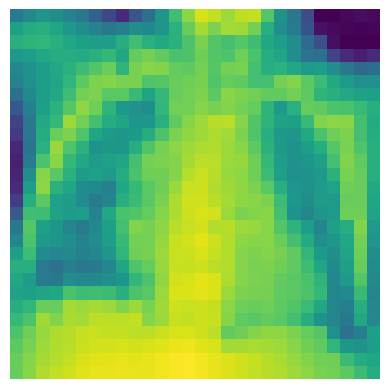

In [3]:
#semplice verifica se ci siano dati mancanti o valori differenti da 0 e 1 per le label
len_y = len(y)
len_image = len(x[0])
count_y = 0
count_x = 0
for i in range(len_y-1):
    if y[i] != 0 and y[i] != 1:
        count_y += 1
    if len(x[i]) != len_image:
        count_x += 1
print("errori nelle label: ",count_y)
print("foto compromesse: ",count_x)

print(x[0].shape)

plt.imshow(x[0])
plt.axis('off')
plt.show()

In [4]:
#verifica sul numero di elementi per classe
lab_one = 0
lab_zero = 0
for i in range(len_y-1):
    if y[i] == 0:
        lab_zero += 1
    else:
        lab_one += 1

print("classe uno ha: ", lab_one," elementi")
print("classe zero ha: ", lab_zero," elementi")

classe uno ha:  3882  elementi
classe zero ha:  1349  elementi


In [5]:
#funzioni utili

def printResults(history):
  pd.DataFrame(history.history).plot(figsize=(5, 3))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show()

## FNN

Si inizia ad affrontare il problema con le reti neurali feedforward. Successivamente si passa alle reti cnn. 
Si esplorano più reti fnn in base al numero di layer e numero di unità per layer.
Le reti avranno in comune gli ultimi 3 livelli densi da 32, 16 e 1 livello, mentre variano i primi livelli.

In [6]:
#definisco un modello per testare dei valori differenti per numero di unità e numero layer
#i layer finali sono fissi con 32 unità e 16 unità, variano gli upper layer, i primi livelli
def build_model(n_layers, units_array):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    
    for i in range(n_layers - 1):
        model.add(keras.layers.Dense(units_array[i], activation='relu'))

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

#funzione utile per addestrare un modello creato con la funziona sopra
#l'addestramento viene sempre arrestato da early stopping, quindi il numero di epoche indicato è 
#sufficiente per l'addestramento completo
def train_model(model):
    model.fit(x_train_images, x_train_labels, epochs=100,
                    verbose=0,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)])

In [7]:
#4 è il numero massimo di upper layer
#il vettore numero di unità è [512,256,128,64]
#se si volessero modificare i valori da testare: max_layer = len(n_units)
n_units = [512,256,128,64]
max_layer = 4

loss_results = []
accuracy_results = []

model_list = []

for i in range(max_layer-1):
    if i == 0:
        cur_model = build_model(max_layer,n_units)
    else:
        cur_model = build_model(max_layer-i,n_units[i:])

    model_list.append(cur_model)
    print("risultati su test set modello:")
    print("layers: ",max_layer-i)
    print("units: ",n_units[i:])
    
    train_model(cur_model)
    cur_loss, cur_acc = cur_model.evaluate(test_images, test_labels)
    
    print("loss: ",cur_loss)
    print("accuracy: ",cur_acc)
    print("\n")
    
    loss_results.append(cur_loss)
    accuracy_results.append(cur_acc)
    

risultati su test set modello:
layers:  4
units:  [512, 256, 128, 64]
17/17 [==============================] - 0s 1ms/step - loss: 0.1062 - accuracy: 0.9656
loss:  0.10620541870594025
accuracy:  0.9656488299369812


risultati su test set modello:
layers:  3
units:  [256, 128, 64]
17/17 [==============================] - 0s 1ms/step - loss: 0.1027 - accuracy: 0.9618
loss:  0.1027301773428917
accuracy:  0.9618320465087891


risultati su test set modello:
layers:  2
units:  [128, 64]
17/17 [==============================] - 0s 1ms/step - loss: 0.1056 - accuracy: 0.9637
loss:  0.10555889457464218
accuracy:  0.9637404680252075




Prendo la miglior rete tra quelle addestrate (la prima), aumento di molto il numero delle epoche e per ridurre l'overfitting si introducono dei livelli di dropout.

In [72]:
def build_fnn_drop_model(dropout):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))

    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model


def train_fnn_drop_model(model):
    model.fit(x_train_images, x_train_labels, epochs=500,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=100)])

fnn_drop = build_fnn_drop_model(0.25)
train_fnn_drop_model(fnn_drop)
print("\n\n")
cur_loss, cur_acc = fnn_drop.evaluate(test_images, test_labels)

Epoch 1/500
132/132 [==============================] - 1s 5ms/step - loss: 0.5887 - accuracy: 0.7160 - val_loss: 0.4116 - val_accuracy: 0.7240
Epoch 2/500
132/132 [==============================] - 0s 3ms/step - loss: 0.3220 - accuracy: 0.8377 - val_loss: 0.2502 - val_accuracy: 0.8860
Epoch 3/500
132/132 [==============================] - 0s 3ms/step - loss: 0.2627 - accuracy: 0.9038 - val_loss: 0.2606 - val_accuracy: 0.8340
Epoch 4/500
132/132 [==============================] - 0s 3ms/step - loss: 0.2351 - accuracy: 0.9216 - val_loss: 0.1873 - val_accuracy: 0.9300
Epoch 5/500
132/132 [==============================] - 0s 3ms/step - loss: 0.2167 - accuracy: 0.9185 - val_loss: 0.2641 - val_accuracy: 0.8880
Epoch 6/500
132/132 [==============================] - 0s 3ms/step - loss: 0.2149 - accuracy: 0.9254 - val_loss: 0.2058 - val_accuracy: 0.9260
Epoch 7/500
132/132 [==============================] - 0s 3ms/step - loss: 0.1975 - accuracy: 0.9308 - val_loss: 0.2055 - val_accuracy: 0.9120

Un ultimo approccio con le reti FNN si basa sul sfruttare la struttura di un autoencoder, ovvero si usa una struttura simmetrica per i primi livelli, con numero di unità che decrescono e poi ricrescono simmetricamente. Questa idea è stata presa da un altro corso e testata.

In [74]:
def build_last_fnn_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))

    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))

    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

def train_last_fnn_model(model):
    model.fit(x_train_images, x_train_labels, epochs=500,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=35)])

last_fnn = build_last_fnn_model()
train_last_fnn_model(last_fnn)
print("\n\n")
cur_loss, cur_acc = last_fnn.evaluate(test_images, test_labels)

Epoch 1/500
132/132 [==============================] - 1s 5ms/step - loss: 0.3480 - accuracy: 0.8527 - val_loss: 0.4512 - val_accuracy: 0.8520
Epoch 2/500
132/132 [==============================] - 0s 3ms/step - loss: 0.1973 - accuracy: 0.9247 - val_loss: 0.5114 - val_accuracy: 0.7820
Epoch 3/500
132/132 [==============================] - 0s 3ms/step - loss: 0.2110 - accuracy: 0.9266 - val_loss: 0.1783 - val_accuracy: 0.9280
Epoch 4/500
132/132 [==============================] - 0s 3ms/step - loss: 0.1733 - accuracy: 0.9344 - val_loss: 0.2069 - val_accuracy: 0.9140
Epoch 5/500
132/132 [==============================] - 0s 3ms/step - loss: 0.1572 - accuracy: 0.9385 - val_loss: 0.2960 - val_accuracy: 0.8840
Epoch 6/500
132/132 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9377 - val_loss: 0.1644 - val_accuracy: 0.9300
Epoch 7/500
132/132 [==============================] - 0s 3ms/step - loss: 0.1526 - accuracy: 0.9408 - val_loss: 0.1737 - val_accuracy: 0.9320

Entrambe le reti FNN ottengono lo stesso valore di accuracy 0.9637, ma i valori di loss sono leggermente differenti. Entrambe raggiungono delle prestazioni interessanti.

## CNN

In [10]:
#a causa di problemi di versioni di python, non si è potuta utilizzare la loss function binary_focal_crossentropy (interessante da provare), in modo diretto.
#per risolvere questi problemi si è usata una versione precedente della funzione di loss che è la sigmoid_focal_crossentropy, che però richiede il seguente import
import tensorflow_addons as tfa

C:\Users\gianl\anaconda3\envs\ML-GPU\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\gianl\anaconda3\envs\ML-GPU\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If y

In [11]:
x_tensor_train = x_train_images.reshape(-1,28,28,1)
x_tensor_valid = x_valid_images.reshape(-1,28,28,1)
test_tensor = test_images.reshape(-1,28,28,1)

Si utilizza come prima rete cnn la rete LeNet, ma come funzioni di attivazioni sono state utilizzate le relu (al posto delle sigmoid). 
Questa rete viene utilizzata anche per testare la miglior loss function per il task in questione.
Come per le reti precedenti, si aggiunge un livello finale per la binary classification.
Inoltre si testa quale sia la miglior operazione del livello di pooling tra max pooling e average pooling. 

In [12]:
def build_lenet(pool_type, loss):
    
    lenet = tf.keras.models.Sequential()
    lenet.add(keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)))
            
    if(pool_type == 1):
        lenet.add(keras.layers.AvgPool2D(pool_size=2, strides=2))
    else:
        lenet.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
            
    lenet.add(keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu'))

    if(pool_type == 1):
        lenet.add(keras.layers.AvgPool2D(pool_size=2, strides=2))
    else:
        lenet.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
            
    lenet.add(keras.layers.Flatten())
    lenet.add(keras.layers.Dense(120, activation='relu'))
    lenet.add(keras.layers.Dense(84, activation='relu'))
    lenet.add(keras.layers.Dense(10, activation='relu'))
    lenet.add(keras.layers.Dense(1, activation='sigmoid'))

    lenet.compile(loss=loss,
              optimizer="adam",
              metrics=["accuracy"])
    return lenet

In [62]:
lenet1 = build_lenet(1,"binary_crossentropy")
lenet2 = build_lenet(2,"binary_crossentropy")

lenet1.fit(x_tensor_train, x_train_labels, epochs=150, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])
lenet2.fit(x_tensor_train, x_train_labels, epochs=150, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])
print("risultati average pooling")
lenet1.evaluate(test_tensor, test_labels)
print("\nrisultati max pooling")
lenet2.evaluate(test_tensor, test_labels)

risultati average pooling
17/17 [==============================] - 0s 1ms/step - loss: 0.0961 - accuracy: 0.9714

risultati max pooling
17/17 [==============================] - 0s 1ms/step - loss: 0.0778 - accuracy: 0.9790


[0.07777874171733856, 0.9790076613426208]

In generale le due operazioni di pooling non hanno prestazioni molto differenti per quanto riguarda l'accuracy sul test set. La loss sul test set in più iterazioni sembra risultare più bassa (di poco) con il max pooling.
Si sceglie dunque il max pooling come livello di pooling dei successivi modelli.

Per la scelta della loss function vengono testate 3 loss function:loss1 = "binary_crossentropy", "mean_squared_error" e "binary_focal_crossentropy" (quest'ultima per problemi di compatibilità, è stata sostituita con la versione precedente "sigmoid_focal_crossentropy"). Vengono testate usando LeNet. 

In [56]:
loss1 = "binary_crossentropy"
loss2 = "mean_squared_error"
loss3 = tfa.losses.sigmoid_focal_crossentropy

lenet_loss1 = build_lenet(2,loss1)
lenet_loss2 = build_lenet(2,loss2)
lenet_loss3 = build_lenet(2,loss3)

lenet_loss1.fit(x_tensor_train, x_train_labels, epochs=200, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)])
lenet_loss2.fit(x_tensor_train, x_train_labels, epochs=200, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)])
lenet_loss3.fit(x_tensor_train, x_train_labels, epochs=200, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)])

print("risultati per binary cross entropy")
lenet_loss1.evaluate(test_tensor, test_labels)
print("\nrisultati per MSE")
lenet_loss2.evaluate(test_tensor, test_labels)
print("\nrisultati per binary focal cross entropy")
lenet_loss3.evaluate(test_tensor, test_labels)

risultati per binary cross entropy
17/17 [==============================] - 0s 1ms/step - loss: 0.1066 - accuracy: 0.9676

risultati per MSE
17/17 [==============================] - 0s 1ms/step - loss: 0.0286 - accuracy: 0.9618

risultati per binary focal cross entropy
17/17 [==============================] - 0s 1ms/step - loss: 0.0126 - accuracy: 0.9771


[0.012580136768519878, 0.9770992398262024]

Si nota come la binary focal cross entropy sia la migliore delle loss function, quindi si utilizza questa come loss function.

Si estende LeNet con altri 3 livelli convoluzionali e due livelli di max pooling. Inoltre tutti i livelli convoluzionali applicano padding in modo tale che dimensione di input = dimensione output.

In [15]:
cnn1 = tf.keras.models.Sequential([
            #input 28x28
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            #input 28x28
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            #input 14x14
            tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'),
            #input 14x14
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            #input 7x7
            tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation='relu', padding='same'),
            #input 7x7
            tf.keras.layers.MaxPool2D(pool_size=2, strides=1),
            #input 6x6
            tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu', padding='same'),
            #input 6x6
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            #input 3x3
            tf.keras.layers.Conv2D(filters=80, kernel_size=3, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')])

cnn1.compile(loss=loss3,
              optimizer="adam",
              metrics=["accuracy"])

cnn1.fit(x_tensor_train, x_train_labels, epochs=200,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)])

Epoch 1/200
132/132 [==============================] - 2s 6ms/step - loss: 0.0322 - accuracy: 0.8039 - val_loss: 0.0195 - val_accuracy: 0.9300
Epoch 2/200
132/132 [==============================] - 0s 4ms/step - loss: 0.0159 - accuracy: 0.9356 - val_loss: 0.0199 - val_accuracy: 0.9460
Epoch 3/200
132/132 [==============================] - 0s 4ms/step - loss: 0.0148 - accuracy: 0.9458 - val_loss: 0.0152 - val_accuracy: 0.9300
Epoch 4/200
132/132 [==============================] - 0s 4ms/step - loss: 0.0137 - accuracy: 0.9432 - val_loss: 0.0161 - val_accuracy: 0.9500
Epoch 5/200
132/132 [==============================] - 0s 4ms/step - loss: 0.0141 - accuracy: 0.9444 - val_loss: 0.0136 - val_accuracy: 0.9420
Epoch 6/200
132/132 [==============================] - 0s 4ms/step - loss: 0.0114 - accuracy: 0.9565 - val_loss: 0.0176 - val_accuracy: 0.9120
Epoch 7/200
132/132 [==============================] - 0s 4ms/step - loss: 0.0109 - accuracy: 0.9563 - val_loss: 0.0201 - val_accuracy: 0.9520

In [16]:
cnn1.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9733


[0.020896177738904953, 0.9732824563980103]

L'accuracy di cnn1 in fase di training è molto alta, in alcune epoche tocca anche il valore 0.99, mentre nel testing l'accuracy scende allo 0.97. Anche la loss aumenta tra training e testing, quindi si cerca di diminuire l'overfitting applicando livelli di dropout.
Si aumentano il numero di epoche e la patience.
Sono stati testati i seguenti valori di dropout:0.10, 0.15, 0.20, 0.25, 0.30. I migliori risultati sono stati ottenuti con dropout 0.25.

In [17]:
def create_cnn2_model():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)))
    #input 28x28
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 14x14
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'))
    #input 14x14
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 7x7
    model.add(tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation='relu', padding='same'))
    #input 7x7
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=1))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 6x6
    model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu', padding='same'))
    #input 6x6
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 3x3
    model.add(tf.keras.layers.Conv2D(filters=80, kernel_size=3, activation='relu'))
            
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(84, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss=loss3,
              optimizer="adam",
              metrics=["accuracy"])
    return model

In [18]:
cnn2 = create_cnn2_model()

cnn2.fit(x_tensor_train, x_train_labels, epochs=200,
                    validation_data=(x_tensor_valid, x_valid_labels))
          #callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=35)])

Epoch 1/200
132/132 [==============================] - 1s 5ms/step - loss: 0.0657 - accuracy: 0.3760 - val_loss: 0.0667 - val_accuracy: 0.5220
Epoch 2/200
132/132 [==============================] - 1s 4ms/step - loss: 0.0506 - accuracy: 0.7517 - val_loss: 0.0501 - val_accuracy: 0.9080
Epoch 3/200
132/132 [==============================] - 1s 4ms/step - loss: 0.0378 - accuracy: 0.8988 - val_loss: 0.0313 - val_accuracy: 0.9180
Epoch 4/200
132/132 [==============================] - 1s 4ms/step - loss: 0.0314 - accuracy: 0.9185 - val_loss: 0.0293 - val_accuracy: 0.9500
Epoch 5/200
132/132 [==============================] - 1s 4ms/step - loss: 0.0302 - accuracy: 0.9133 - val_loss: 0.0282 - val_accuracy: 0.9480
Epoch 6/200
132/132 [==============================] - 1s 4ms/step - loss: 0.0248 - accuracy: 0.9318 - val_loss: 0.0218 - val_accuracy: 0.9460
Epoch 7/200
132/132 [==============================] - 1s 4ms/step - loss: 0.0248 - accuracy: 0.9287 - val_loss: 0.0212 - val_accuracy: 0.9360

In [19]:
cnn2.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9790


[0.006713542155921459, 0.9790076613426208]

Ultima modifica che si effettua a cnn2 è aumentare il numero di livelli dense e il numero di unità di tali livelli.
Si utilizzano anche livelli di dropout per diminuire l'overfitting.

In [20]:
def create_cnn3_model():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)))
    #input 28x28
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 14x14
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'))
    #input 14x14
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 7x7
    model.add(tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation='relu', padding='same'))
    #input 7x7
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=1))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 6x6
    model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu', padding='same'))
    #input 6x6
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 3x3
    model.add(tf.keras.layers.Conv2D(filters=80, kernel_size=3, activation='relu'))
            
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss=loss2,
              optimizer="adam",
              metrics=["accuracy"])
    return model

In [30]:
cnn3 = create_cnn3_model()
cnn3.fit(x_tensor_train, x_train_labels, epochs=200,
                    validation_data=(x_tensor_valid, x_valid_labels))

Epoch 1/200
132/132 [==============================] - 2s 7ms/step - loss: 0.1880 - accuracy: 0.7384 - val_loss: 0.2263 - val_accuracy: 0.7240
Epoch 2/200
132/132 [==============================] - 1s 5ms/step - loss: 0.1270 - accuracy: 0.8099 - val_loss: 0.0929 - val_accuracy: 0.8860
Epoch 3/200
132/132 [==============================] - 1s 5ms/step - loss: 0.0970 - accuracy: 0.8769 - val_loss: 0.0949 - val_accuracy: 0.8820
Epoch 4/200
132/132 [==============================] - 1s 5ms/step - loss: 0.0823 - accuracy: 0.8945 - val_loss: 0.0778 - val_accuracy: 0.8960
Epoch 5/200
132/132 [==============================] - 1s 5ms/step - loss: 0.0728 - accuracy: 0.9059 - val_loss: 0.0561 - val_accuracy: 0.9260
Epoch 6/200
132/132 [==============================] - 1s 5ms/step - loss: 0.0690 - accuracy: 0.9114 - val_loss: 0.1067 - val_accuracy: 0.8720
Epoch 7/200
132/132 [==============================] - 1s 5ms/step - loss: 0.0627 - accuracy: 0.9223 - val_loss: 0.0498 - val_accuracy: 0.9320

In [31]:
cnn3.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 4ms/step - loss: 0.0213 - accuracy: 0.9752


[0.0213365126401186, 0.9751908183097839]

L'ultimo modello che si testa cerca di simulare il comportamento di un Inception Block. Quindi ci sono i primi quattro modelli ch1, ch2, ch3 e ch4 che corrispondono ai 4 flussi paralleli dell'Inception Block. Il quinto modello, rest, riceve in input la concatenazione degli output dei quattro modelli iniziali. 
Per la struttura di rest, sono stati anche testati dei livelli convoluzionali seguiti da livelli dense, che però non hanno migliorato le prestazioni in modo significativo, per tanto la versione finale presenta solo livelli dense.
Anche per il numero di filtri e il padding utilizzato nei livelli convoluzionali dei 4 modelli iniziali sono stati testati differenti valori ma i migliori sono quelli riportati nella cella sottostante.

In [23]:
from tensorflow.keras.layers import Input, Concatenate, Flatten
from tensorflow.keras.models import Model

def create_channel_1():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=1, activation='relu'))
    #output 28x28
    return model

def create_channel_2():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=1, activation='relu', input_shape=(28, 28, 1)))
    #output 28x28
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation='relu', padding='same'))
    #output 28x28
    return model

def create_channel_3():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=1, activation='relu', padding='same', input_shape=(28, 28, 1)))
    #output 28x28
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=5, activation='relu', padding='same'))
    #output 28x28
    return model

def create_channel_4():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))
    #output 28x28
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=1, activation='relu', padding='same'))
    #output 28x28
    return model

ch1 = create_channel_1()
ch2 = create_channel_2()
ch3 = create_channel_3()
ch4 = create_channel_4()

input1 = Input(shape=(28, 28, 1))
input2 = Input(shape=(28, 28, 1))
input3 = Input(shape=(28, 28, 1))
input4 = Input(shape=(28, 28, 1))

output1 = ch1(input1)
output2 = ch2(input2)
output3 = ch3(input3)
output4 = ch4(input4)

concatenated = tf.concat([output1, output2, output3, output4], axis=3)

def model_post_inception():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 12)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

rest = model_post_inception()
final_output = rest(concatenated)

final_model = Model(inputs=[input1, input2, input3, input4], outputs=final_output)

final_model.compile(optimizer='adam', loss=tfa.losses.sigmoid_focal_crossentropy, metrics=['accuracy'])

final_model.fit([x_tensor_train, x_tensor_train, x_tensor_train, x_tensor_train], 
                x_train_labels, epochs=300,
                    validation_data=([x_tensor_valid, x_tensor_valid, x_tensor_valid, x_tensor_valid], 
                                     x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)])

Epoch 1/300
132/132 [==============================] - 2s 7ms/step - loss: 0.0669 - accuracy: 0.5582 - val_loss: 0.0378 - val_accuracy: 0.8560
Epoch 2/300
132/132 [==============================] - 1s 5ms/step - loss: 0.0308 - accuracy: 0.8743 - val_loss: 0.0266 - val_accuracy: 0.8760
Epoch 3/300
132/132 [==============================] - 1s 5ms/step - loss: 0.0211 - accuracy: 0.9240 - val_loss: 0.0245 - val_accuracy: 0.9240
Epoch 4/300
132/132 [==============================] - 1s 5ms/step - loss: 0.0185 - accuracy: 0.9282 - val_loss: 0.0244 - val_accuracy: 0.9360
Epoch 5/300
132/132 [==============================] - 1s 5ms/step - loss: 0.0179 - accuracy: 0.9339 - val_loss: 0.0173 - val_accuracy: 0.9220
Epoch 6/300
132/132 [==============================] - 1s 5ms/step - loss: 0.0160 - accuracy: 0.9404 - val_loss: 0.0175 - val_accuracy: 0.9280
Epoch 7/300
132/132 [==============================] - 1s 5ms/step - loss: 0.0153 - accuracy: 0.9442 - val_loss: 0.0173 - val_accuracy: 0.9340

In [24]:
final_model.evaluate([test_tensor, test_tensor, test_tensor, test_tensor], test_labels)

17/17 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9714


[0.023670228198170662, 0.9713740348815918]

In questa cella si stampa l'immagine del modello che simula un Inception Block.

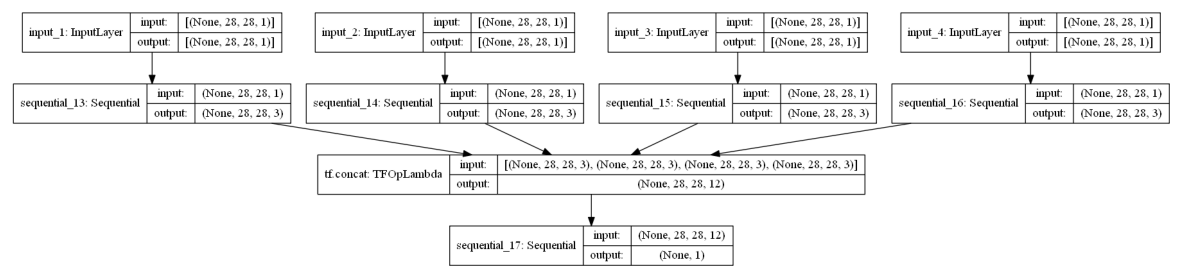

In [25]:
from tensorflow.keras.utils import plot_model
import pydot

plot_model(final_model, to_file='model_represent.png', show_shapes=True, show_layer_names=True)

img = plt.imread('model_represent.png')
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

Nella cella sottostante si è implementata una classe per calcolare i valori delle metriche precision, recall, f1 score e anche ottenere la confusion matrix.
Per il calcolo di questi valori è necessario applicare una threshold per ottenere le etichette delle predizioni. Come threshold si è scelto il valore 0.5 poichè dalla documentazione si evince che è la stessa threshold utilizzata dalla funzione sigmoid.

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

class ModelEval:
    def __init__(self, model, isTensor):
        self.model = model
        if(isTensor):
            self.predictions = self.model.predict(test_tensor)  
        else:
            self.predictions = self.model.predict(test_images)
    
        self.y_pred = (self.predictions > 0.5).astype("int32")
        self.prec = 0
        self.rec = 0
        self.f1 = 0
    
    def calculate_precision(self):
        self.prec = precision_score(test_labels, self.y_pred)
        print("Precision:",self.prec)

    def calculate_recall(self):
        self.rec = recall_score(test_labels, self.y_pred)
        print("Recall:",self.rec)

    def calculate_f1(self):
        self.f1 = f1_score(test_labels, self.y_pred)
        print("F1 Score:",self.f1)

    def print_confusion_matrix(self):
        cm = confusion_matrix(test_labels, self.y_pred)
        plt.figure(figsize=(4, 2))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.title("Confusion Matrix")
        plt.show()

I modelli addestrati e i loro valori di accuracy e loss su test set sono i seguenti:

fnn_drop   loss: 0.1005 - accuracy: 0.9637

last_fnn   loss: 0.1156 - accuracy: 0.9637

lenet2   loss: 0.0778 - accuracy: 0.9790

cnn1   loss: 0.0209 - accuracy: 0.9733

cnn2   loss: 0.0067 - accuracy: 0.9790

cnn3   loss: 0.0213 - accuracy: 0.9752

final_model   loss: 0.0237 - accuracy: 0.9714

Possiamo notare come le reti CNN hanno ottenuto risultati migliori sia su accuracy sia su loss rispetto alle reti FNN.
I migliori modelli sono lenet2 e cnn2.

Di seguito si riportano i valori di precision, recall e f1 score dei due modelli migliori.

In [63]:
eval_lenet2 = ModelEval(lenet2,True)
print("\nlenet2 results")
eval_lenet2.calculate_precision()
eval_lenet2.calculate_recall()
eval_lenet2.calculate_f1()
print("\ncnn2 results")
eval_cnn2 = ModelEval(cnn2,True)
eval_cnn2.calculate_precision()
eval_cnn2.calculate_recall()
eval_cnn2.calculate_f1()


lenet2 results
Precision: 0.9900249376558603
Recall: 0.9826732673267327
F1 Score: 0.986335403726708

cnn2 results
Precision: 0.9924812030075187
Recall: 0.9801980198019802
F1 Score: 0.9863013698630136


Confusion matrix per il modello lenet2


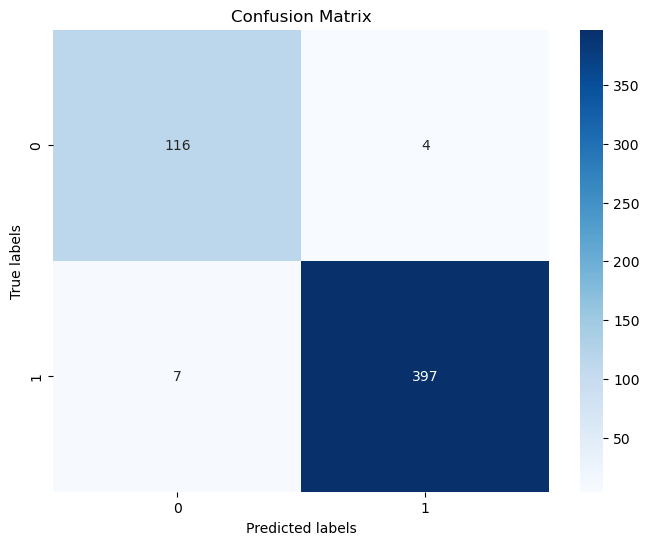


Confusion matrix per il modello cnn2


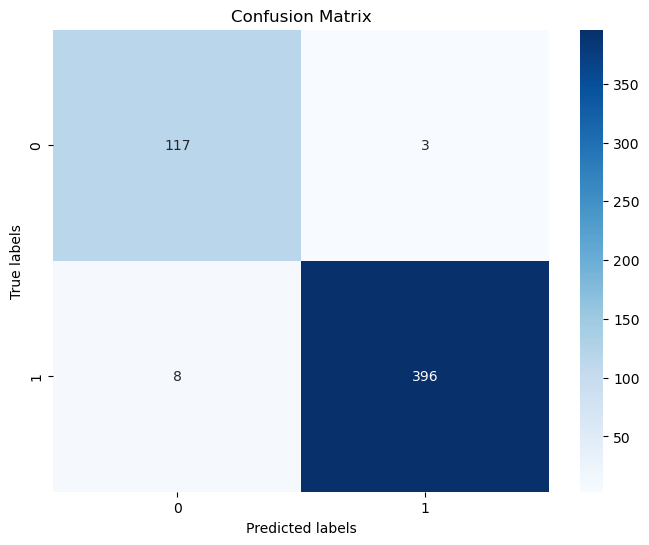

In [78]:
print("Confusion matrix per il modello lenet2")
eval_lenet2.print_confusion_matrix()
print("\nConfusion matrix per il modello cnn2")
eval_cnn2.print_confusion_matrix()

Possiamo notare come i valori di precision e recall siano molto alti per entrambi i modelli, dove la rete cnn2 ha una precision di poco maggiore, mentre la rete lenet2 ha una recall leggermente maggiore.
La rete lenet2 ha un valore di F1 score leggermente maggiore della seconda rete.

Dalla confusion matrix possiamo osservare come il test sia formato da molti dati della classe 1, di cui quasi la totalità è stata correttamente etichettata. Similmente per i dati della classe 0, che possiede meno dati. La disparità nella presenza delle classi nel test set dipende anche dal fatto che la classe 1 possiede il triplo di dati rispetto alla classe 0.

Poichè la classe 1 corrisponde alle radiografie dei pazienti che presentano polmonite, si sceglie il modello con recall maggiore e con meno errori sugli elementi della classe 1, ovvero il modello lenet2. 
Quindi in conclusione si sceglie come modello migliore il modello lenet2, ovvero un modello identico al modello lenet che utilizza la relu come funzione di attivazione e MaxPooling come tipologia di pooling. I risultati migliori sono dunque i seguenti:

Loss: 0.0778 

Accuracy: 0.9790

Precision: 0.9900

Recall: 0.9827

F1 Score: 0.9863g.

OSSERVAZIONI GENERALI

Nella ricerca dei migliori parametri molti test non sono stati riportati nel notebook. Sono stati testati molti modelli di reti neurali con numero differenti di livelli convoluzionali, in alcuni casi il numero di layer era talmente eccessivo che il modello aveva zero capacità di generalizzazione. 

Sono stati testati anche differenti dimensioni per i filtri, ovvero valori 3,5,7,11. I miglior valori sono stati 5 e 3. Anche il numero di filtri è stato fatto variare. Dai vari test si è notato che un numero eccessivo come numero di filtri (come atteso) comporta overfitting. 

Si può notare come le reti FNN abbiamo molti più parametri delle reti CNN ed che l'addestramento delle reti FNN richiede meno tempo. Nonostante il modello migliore sia una rete CNN, anche le reti FNN hanno ottenuto risultati interessanti.

Per le reti FNN sono stati testate differenti configurazioni di livelli e numero di unità per livello. La miglior configurazione sembra essere quella della rete fnn_drop, ovvero partire con un livello con numero di unità molto alto e diminuendo progressivamente il numero di unità.

